## Check data augmentation

In [1]:
import os
import sys
import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, erosion
import matplotlib.pyplot as plt
%matplotlib inline

CHALLENGE_PATH = '../challenge_data/'
TRAIN_PATH = os.path.join(CHALLENGE_PATH, 'challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Data/')
TEST_PATH = os.path.join(CHALLENGE_PATH, 'challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/')
TOOLS_PATH = os.path.join(CHALLENGE_PATH, 'challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Tools/')
DEFAULT_SIZE = [175,152,152]
sys.path.append(TOOLS_PATH)
from Image3D import Image3D
from ImageIO import ImageIO
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as met
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from progressbar import ProgressBar

def load_outputs(output_path=CHALLENGE_PATH):
    csv_path = os.path.join(output_path,"challenge_fichier_de_sortie_dentrainement_prediction_de_la_saturation_dhuile_residuelle.csv")
    return pd.read_csv(csv_path,sep=';')

input_ims = [os.path.join(TRAIN_PATH, pa) for pa in os.listdir(TRAIN_PATH) if 'input' in pa]
outputs_ims = [os.path.join(TRAIN_PATH, pa) for pa in os.listdir(TRAIN_PATH) if 'output' in pa]
# Targets
outputs = load_outputs()
# Sort by sor values
input_idx = np.array([int(pa.split('/')[-1].split('_')[-1].split('.')[0]) for pa in input_ims])
output_idx = np.array([int(pa.split('/')[-1].split('_')[-1].split('.')[0]) for pa in outputs_ims])
# Sort the values
input_ims = np.array(input_ims)[np.argsort(input_idx)]
outputs_ims = np.array(outputs_ims)[np.argsort(output_idx)]

## Get the SOR formula

In [2]:
from sor_formula import compute_sor

### Create new samples of size 30 x 152 x 152 and use compute_sor
If from the compute_sor features of the sub-blocks we can get the whole SOR easily it's win

In [3]:
compute_sor_features = []

volumes_starts = [0, 20, 40, 60, 80, 100, 120, 140]
volume = 30

for idi, outpa in enumerate(outputs_ims):
    # Load Binary image and output image
    outim = ImageIO(outpa).read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2])
    out_image = outim.get_whole_array()
    sample_sor_feats = []
    # Create the smaller volumes
    for multite in volumes_starts:
        small_outimage = out_image[multite:multite + volume]
        sample_sor_feats.append(np.mean(1. * (small_outimage[small_outimage > 1] == 4)))
    compute_sor_features.append(sample_sor_feats)

compute_sor_features = np.array(compute_sor_features)
# Get the real outputs
y_classi = 1 * (outputs.material.values == 'Clash')
y_sor = outputs.sor.values

## Try to predict sor

In [5]:
# Add the y_classi to the features 
X = np.concatenate([compute_sor_features, y_classi.reshape(-1,1)], axis=1)
train, test, y_sor_train, y_sor_test = train_test_split(X, y_sor, test_size=0.3)

clf = LinearRegression()
clf.fit(train, y_sor_train)

print('R2 train:', met.r2_score(y_sor_train, clf.predict(train)))
print('MSE train:', met.mean_squared_error(y_sor_train, clf.predict(train)))
print('R2 test:', met.r2_score(y_sor_test, clf.predict(test)))
print('MSE test:', met.mean_squared_error(y_sor_test, clf.predict(test)))

R2 train: 0.9975508394384673
MSE train: 2.7841330775505493e-05
R2 test: 0.9983462807116726
MSE test: 1.7205005074705476e-05


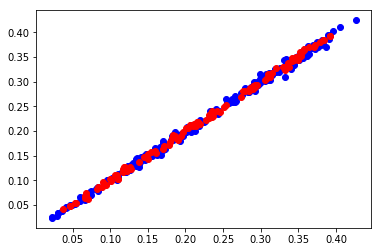

In [8]:
plt.figure()
plt.plot(y_sor_train, clf.predict(train), 'bo')
plt.plot(y_sor_test, clf.predict(test), 'ro')